In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import *
from IPython.display import Image
import matplotlib.ticker as mtick
import matplotlib

import scipy.stats as stats
import statsmodels.stats.weightstats as wstats
from collections import OrderedDict

from __future__ import print_function
from __future__ import division
%matplotlib inline

In [3]:
import psycopg2 as ps
import pandas as pd

In [5]:
def view(query):
    conn = ps.connect("host='redshift.service.aws2' port='5439' dbname='production' user='ggiorcelli' password='Gg1234590'")
    cur = conn.cursor()
    cur.execute(query)  
    data=cur.fetchall()
    col_names = []
    for elt in cur.description:
        col_names.append(elt[0])
     
    df = pd.DataFrame(data, columns=col_names)
    return df
    conn.close()

In [10]:
query = "select count(distinct l.f_location_id) dealers, count(distinct l.k_lead_id) gross_leads, count(distinct l.f_email) unique_submitters from main.f_dealer_lead l where l.f_date between '01-01-2016' and '03-18-2016' and l.f_type = 'new' "
df = pd.DataFrame(view(query))
df

,dealers,gross_leads,unique_submitters
0,8510,483095,129522


In [11]:
query = "select count(distinct l.f_location_id) dealers, count(distinct l.k_lead_id) gross_leads, count(distinct l.f_email) unique_submitters from main.f_dealer_lead l where l.f_date between '01-01-2017' and '03-18-2017' and l.f_type = 'new' "
df1 = pd.DataFrame(view(query))
df1

,dealers,gross_leads,unique_submitters
0,9701,608541,176536


In [80]:
129522/8510

15.219976498237369

In [81]:
176536/9701

18.197711576126174

In [82]:
(18-15)/15

0.2

In [11]:
#Conections
df1 = df.loc[[0]]
df1

,metrics,u_value,u_sessions,n1_value,n1_sessions,n2_value,n2_sessions
0,connections,496,33561,5317,485764,590,50808


 A: Leads = 129522 	 Dealers = 8510 	 prop = 15.219976498237369
 B: Leads = 176536 	 Dealers = 9701 	 prop = 18.197711576126174


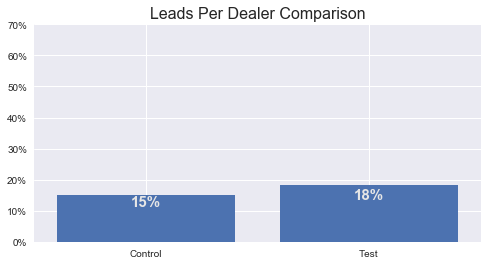

In [83]:
control_base = df.dealers[0]
control_value = df.unique_submitters[0]
test_base = df1.dealers[0]
test_value = df1.unique_submitters[0]


print(' {}: Leads = {} \t Dealers = {} \t prop = {}'
      .format('A', control_value, control_base, control_value/control_base))

print(' {}: Leads = {} \t Dealers = {} \t prop = {}'
      .format('B', test_value, test_base, test_value/test_base))


fig, ax = plt.subplots(figsize=(8,4))

x = [0,1]
y = [control_value/control_base, test_value/test_base]
ax.bar(x, y, align='center', width=.8)
ax.set_xticks(x)
ax.set_xticklabels(['Control', 'Test'])
xlim(-.5,1.5)
ylim(0, 70)
for xx, yy in zip(x,y):
    ax.text(xx, yy*.7, '%0.0f%%'%(yy),ha='center', va='bottom', fontdict={'size':15,'weight':'bold','color':(0.9,.9,.9)})
# ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
# def perc(x, pos=0):
#     return '%0.0f%%'%(100*x)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos=0: '%0.0f%%'%(x)))
title('Leads Per Dealer Comparison', fontdict={'size':16})

In [96]:
from statsmodels.stats.proportion import proportions_ztest
count = np.array([test_value, control_value])
nobs = np.array([test_base*100, control_base*100])
z,p = proportions_ztest(count, nobs, value=0, alternative='two-sided')
print(' z-stat = {z} \n p-value = {p}'.format(z=z,p=p))


 z-stat = 53.61814468228941 
 p-value = 0.0


In [94]:
# implementation from scratch
def compute_standard_error_prop_two_samples(x1, n1, x2, n2, alpha=0.05):
    p1 = x1/n1
    p2 = x2/n2    
    se = p1*(1-p1)/n1 + p2*(1-p2)/n2
    return sqrt(se)
    
def zconf_interval_two_samples(x1, n1, x2, n2, alpha=0.05):
    p1 = x1/n1
    p2 = x2/n2    
    se = compute_standard_error_prop_two_samples(x1, n1, x2, n2)
    z_critical = stats.norm.ppf(1-0.5*alpha)
    return p2-p1-z_critical*se, p2-p1+z_critical*se

ci_low,ci_upp = zconf_interval_two_samples(test_base*10, test_value,
                                           control_base*10, control_value)
print(' 95% Confidence Interval = ( {0:.2f}% , {1:.2f}% )'
      .format(100*ci_low, 100*ci_upp))

 95% Confidence Interval = ( 10.40% , 11.10% )


 A: Leads = 483095 	 Dealers = 8510 	 prop = 0.017615582856374004
 B: Leads = 608541 	 Dealers = 9701 	 prop = 0.01594140739900845


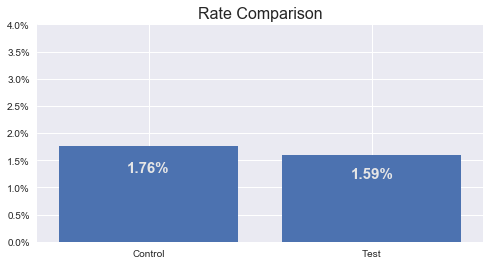

In [71]:
control_base = df.dealers[0]
control_value = df.gross_leads[0]
test_base = df1.dealers[0]
test_value = df1.gross_leads[0]


print(' {}: Leads = {} \t Dealers = {} \t prop = {}'
      .format('A', control_value, control_base, control_base/control_value))

print(' {}: Leads = {} \t Dealers = {} \t prop = {}'
      .format('B', test_value, test_base, test_base/test_value))


fig, ax = plt.subplots(figsize=(8,4))

ax.bar(x, y, align='center', width=.8)
ax.set_xticks(x)
ax.set_xticklabels(['Control', 'Test'])
xlim(-.5,1.5)
ylim(0, .04)
for xx, yy in zip(x,y):
    ax.text(xx, yy*.7, '%0.2f%%'%(100*yy),ha='center', va='bottom', fontdict={'size':15,'weight':'bold','color':(0.9,.9,.9)})
# ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
# def perc(x, pos=0):
#     return '%0.0f%%'%(100*x)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos=0: '%0.1f%%'%(100.0*x)))
title('Rate Comparison', fontdict={'size':16})

In [75]:
from statsmodels.stats.proportion import proportions_ztest
count = np.array([test_value, control_value])
nobs = np.array([test_base*100, control_base*100])
z,p = proportions_ztest(count, nobs, value=0, alternative='two-sided')
print(' z-stat = {z} \n p-value = {p}'.format(z=z,p=p))

 z-stat = 81.91743887703521 
 p-value = 0.0


In [78]:
# implementation from scratch
def compute_standard_error_prop_two_samples(x1, n1, x2, n2, alpha=0.05):
    p1 = x1/n1
    p2 = x2/n2    
    se = p1*(1-p1)/n1 + p2*(1-p2)/n2
    return sqrt(se)
    
def zconf_interval_two_samples(x1, n1, x2, n2, alpha=0.05):
    p1 = x1/n1
    p2 = x2/n2    
    se = compute_standard_error_prop_two_samples(x1, n1, x2, n2)
    z_critical = stats.norm.ppf(1-0.5*alpha)
    return p2-p1-z_critical*se, p2-p1+z_critical*se

ci_low,ci_upp = zconf_interval_two_samples(test_value, test_base*100,
                                           control_value, control_base*100)
print(' 95% Confidence Interval = ( {0:.2f}% , {1:.2f}% )'
      .format(100*ci_low, 100*ci_upp))

 95% Confidence Interval = ( -6.10% , -5.82% )


In [7]:
import pymc3
import pylab

In [9]:
help(pymc)

Help on package pymc:

NAME
    pymc

PACKAGE CONTENTS
    code_maintenance
    pymc (package)
    setup
    setupegg

FILE
    (built-in)




In [15]:
# using pymc3
import pymc as pm
import pymc3 as pm3

control   = [1]*df1.n1_value[0] + [0]*(df1.n1_sessions[0] - df1.n1_value[0])
treatment = [1]*df1.n2_value[0] + [0]*(df1.n2_sessions[0] - df1.n2_value[0])
control = np.asarray(control)
treatment = np.asarray(treatment)

start = {}

start['p_C'] = (control).sum()/len(control)
start['p_T'] = (treatment).sum()/len(treatment)

In [ ]:
data = treatment

with pm3.Model() as model:
    mu = pm3.Normal('mu', mu=0, sd=1, testval=0)
    sd = pm3.HalfNormal('sd', sd=1)
    n = pm3.Normal('n', mu=mu, sd=sd, observed=data)

    trace = pm3.sample(3000)

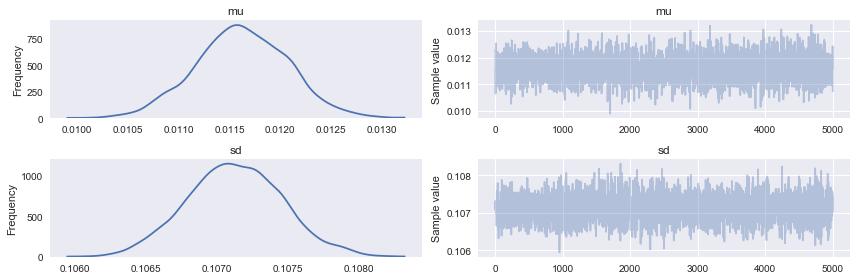

In [150]:
pm3.traceplot(trace);